# Import File dan Cek Data

In [27]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

In [3]:
# read data
df = pd.read_csv('../Dataset/dailyActivity_merged.csv')

In [4]:
# cek shape
print(df.shape)

(940, 15)


In [5]:
df.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [6]:
df.nunique()

Id                           33
ActivityDate                 31
TotalSteps                  842
TotalDistance               615
TrackerDistance             613
LoggedActivitiesDistance     19
VeryActiveDistance          333
ModeratelyActiveDistance    211
LightActiveDistance         491
SedentaryActiveDistance       9
VeryActiveMinutes           122
FairlyActiveMinutes          81
LightlyActiveMinutes        335
SedentaryMinutes            549
Calories                    734
dtype: int64

# Bagaimana jika dailyActivity_merged digabung dengan sleepDay dan weightLogInfo?

Read sleepDay dan weightLogInfo

In [31]:
df_sleepDay = pd.read_csv('../Dataset/sleepDay_merged.csv')
df_weightLogInfo = pd.read_csv('../Dataset/weightLogInfo_merged.csv')

# ubah timestamp jadi activityday semua
df_sleepDay.rename(columns={'SleepDay': 'ActivityDate'}, inplace=True)
df_weightLogInfo.rename(columns={'Date': 'ActivityDate'}, inplace=True)

# Menghapus bagian waktu (jam menit detik) dari 'ActivityDay' di df_sleepDay dan df_weightLogInfo
df_sleepDay['ActivityDate'] = df_sleepDay['ActivityDate'].str.split(' ').str[0]
df_weightLogInfo['ActivityDate'] = df_weightLogInfo['ActivityDate'].str.split(' ').str[0]

# Konversi kolom 'ActivityDate' menjadi format datetime
df_sleepDay['ActivityDate'] = pd.to_datetime(df_sleepDay['ActivityDate'], format='%m/%d/%Y')
df_weightLogInfo['ActivityDate'] = pd.to_datetime(df_weightLogInfo['ActivityDate'], format='%m/%d/%Y')

Merge

In [34]:
merged_df = pd.merge(df, df_sleepDay[['Id', 'ActivityDate', 'TotalMinutesAsleep', 'TotalTimeInBed']], on=['Id', 'ActivityDate'], how='outer')
merged_df = pd.merge(merged_df, df_weightLogInfo[['Id', 'ActivityDate', 'WeightKg']], on=['Id', 'ActivityDate'], how='outer')

print(merged_df.shape)
print(merged_df.info())

(943, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        943 non-null    int64         
 1   ActivityDate              943 non-null    datetime64[ns]
 2   TotalSteps                943 non-null    int64         
 3   TotalDistance             943 non-null    float64       
 4   TrackerDistance           943 non-null    float64       
 5   LoggedActivitiesDistance  943 non-null    float64       
 6   VeryActiveDistance        943 non-null    float64       
 7   ModeratelyActiveDistance  943 non-null    float64       
 8   LightActiveDistance       943 non-null    float64       
 9   SedentaryActiveDistance   943 non-null    float64       
 10  VeryActiveMinutes         943 non-null    int64         
 11  FairlyActiveMinutes       943 non-null    int64         
 12  LightlyActiv

Terlalu banyak Null, terutama pada kolom yang berasal dari sleepDay dan weightLogInfo. Untuk itu, selanjutnya akan menggunakan data daily_Activity_merged saja.

# Mengecek Distribusi Data dengan Boxplot untuk Memeriksa Outlier

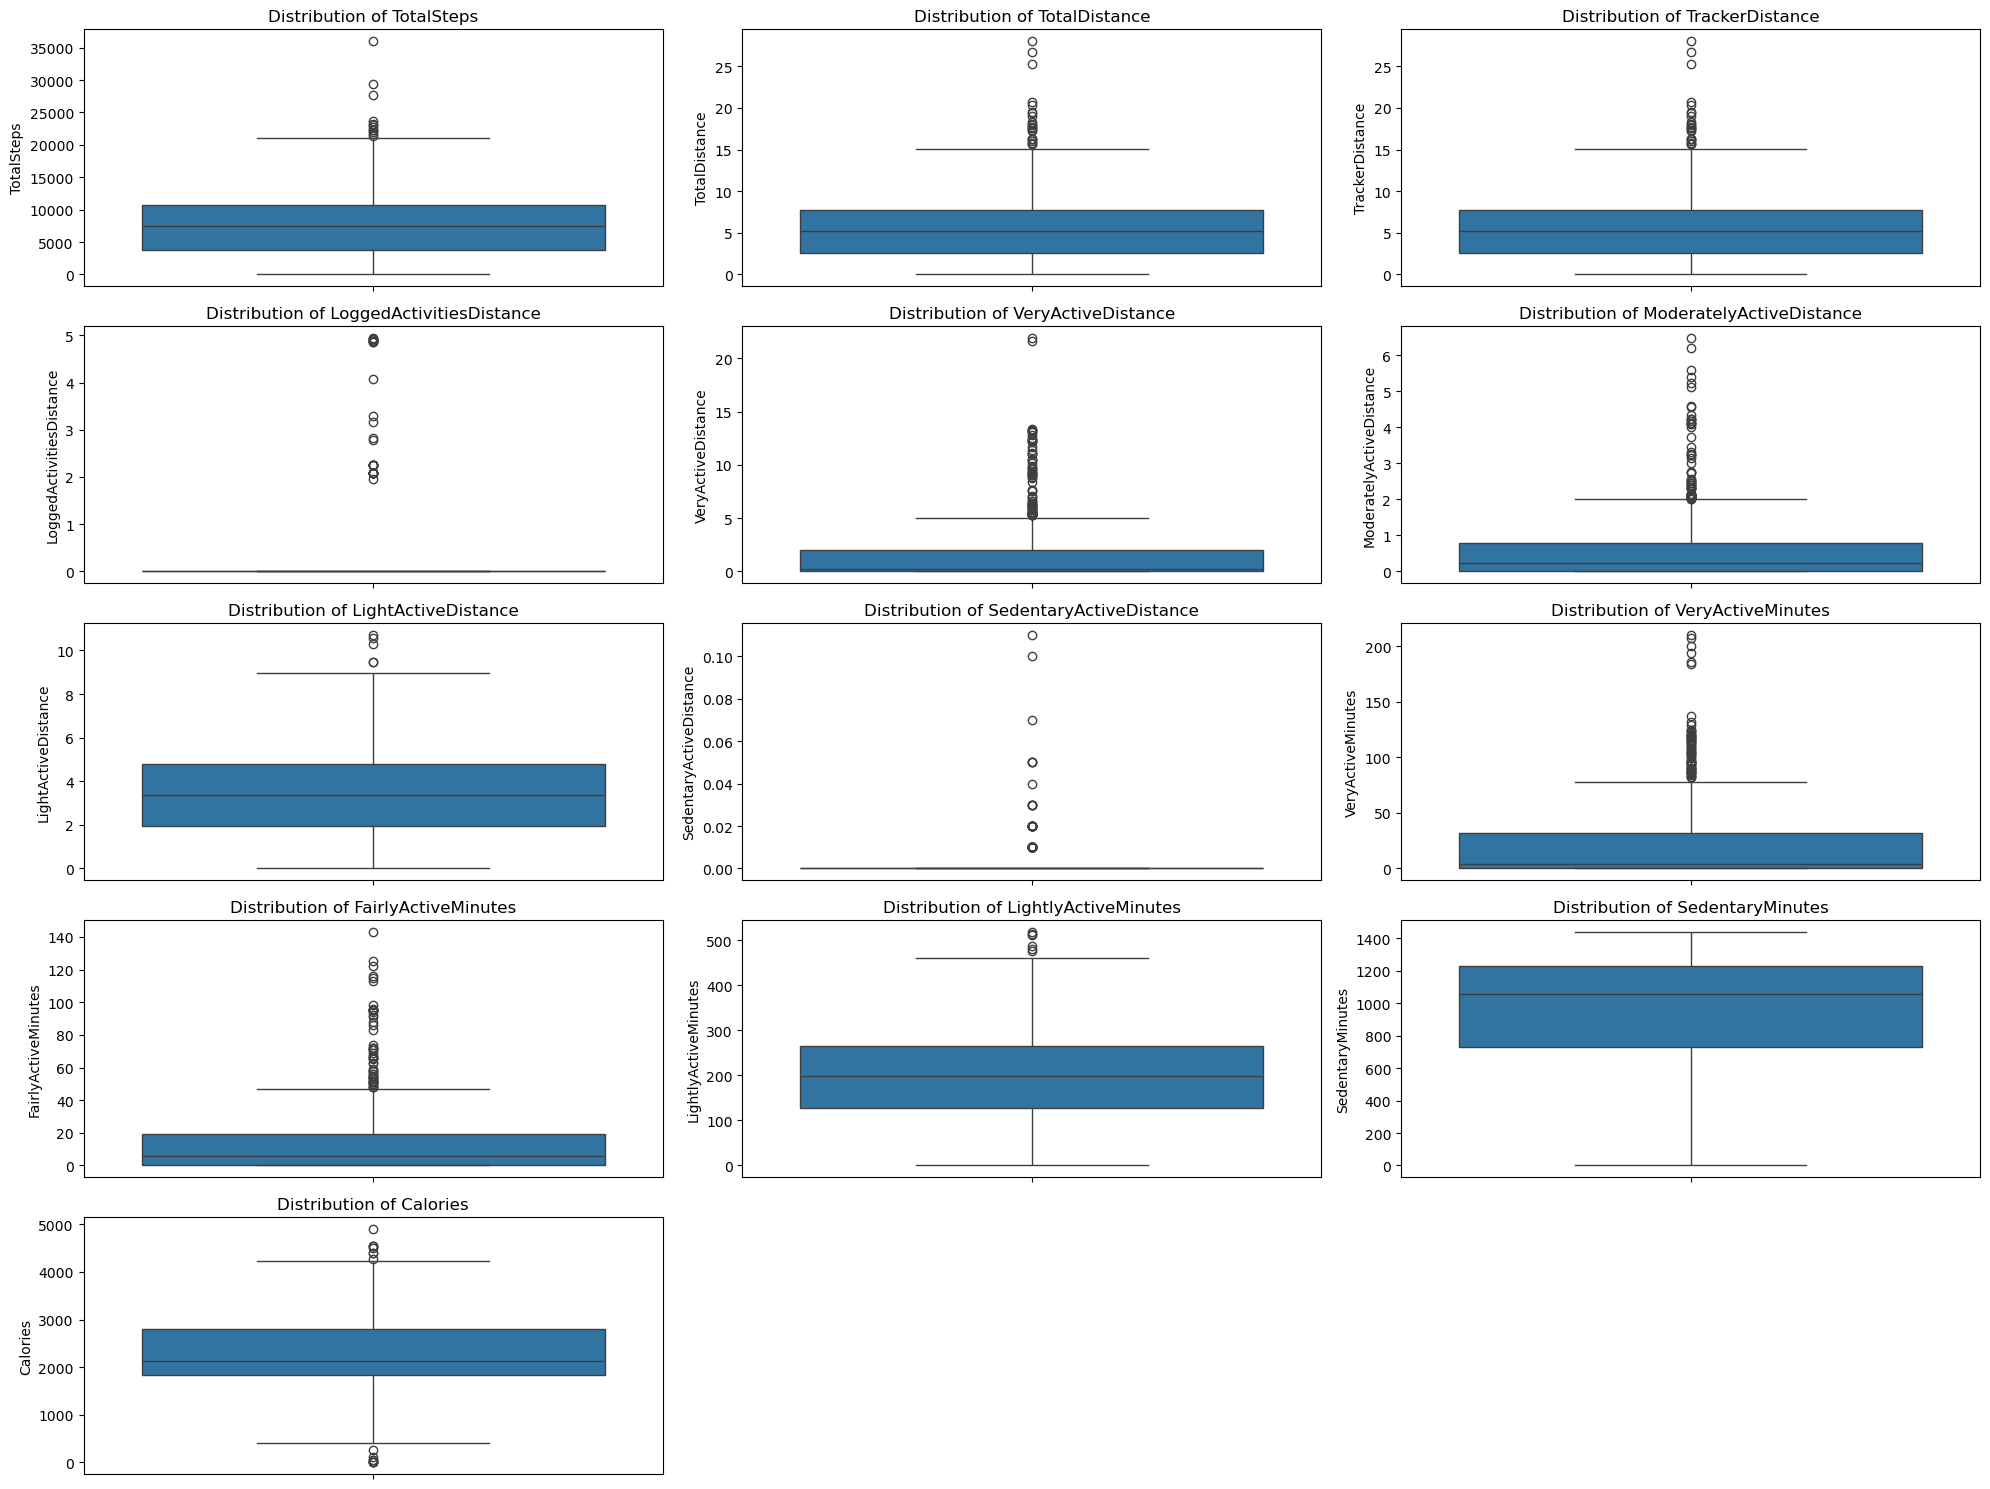

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
columns_to_check = [
    'TotalSteps', 'TotalDistance', 'TrackerDistance', 'LoggedActivitiesDistance', 
    'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 
    'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes', 
    'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories'
]

# Plot distribusi setiap kolom untuk melihat adanya outlier
plt.figure(figsize=(20, 15))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(5, 3, i)  # Menampilkan 5 baris dan 3 kolom plot
    sns.boxplot(df[column])
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

Terdapat beberapa outlier. Untuk sementara, outlier tidak dihandle karena kami menganggap bahwa data ini real. Untuk pengguna yang dianggap outlier, bisa saja mereka adalah atlet sehingga aktivitas mereka lebih banyak daripada orang lain.

# Melihat Rata-Rata Aktivitas Per Hari

Convert dulu ke DateTime, kemudian ambil nama harinya

In [10]:
df['ActivityDate'] = pd.to_datetime(df['ActivityDate'], format='%m/%d/%Y')
# Mendapatkan nama hari dari tanggal
df['DayName'] = df['ActivityDate'].dt.day_name() 


Rata-rata per user dulu memastikan semua pengguna punya bobot yang sama, jadi pengguna yang sangat aktif atau punya banyak data tidak mendominasi hasil. Misalnya pengguna A sudah menggunakan Fitbit selama berbulan-bulan, sementara pengguna B baru seminggu. Jika kita langsung rata-rata semua data, pengguna A yang punya lebih banyak data akan mendominasi hasil.

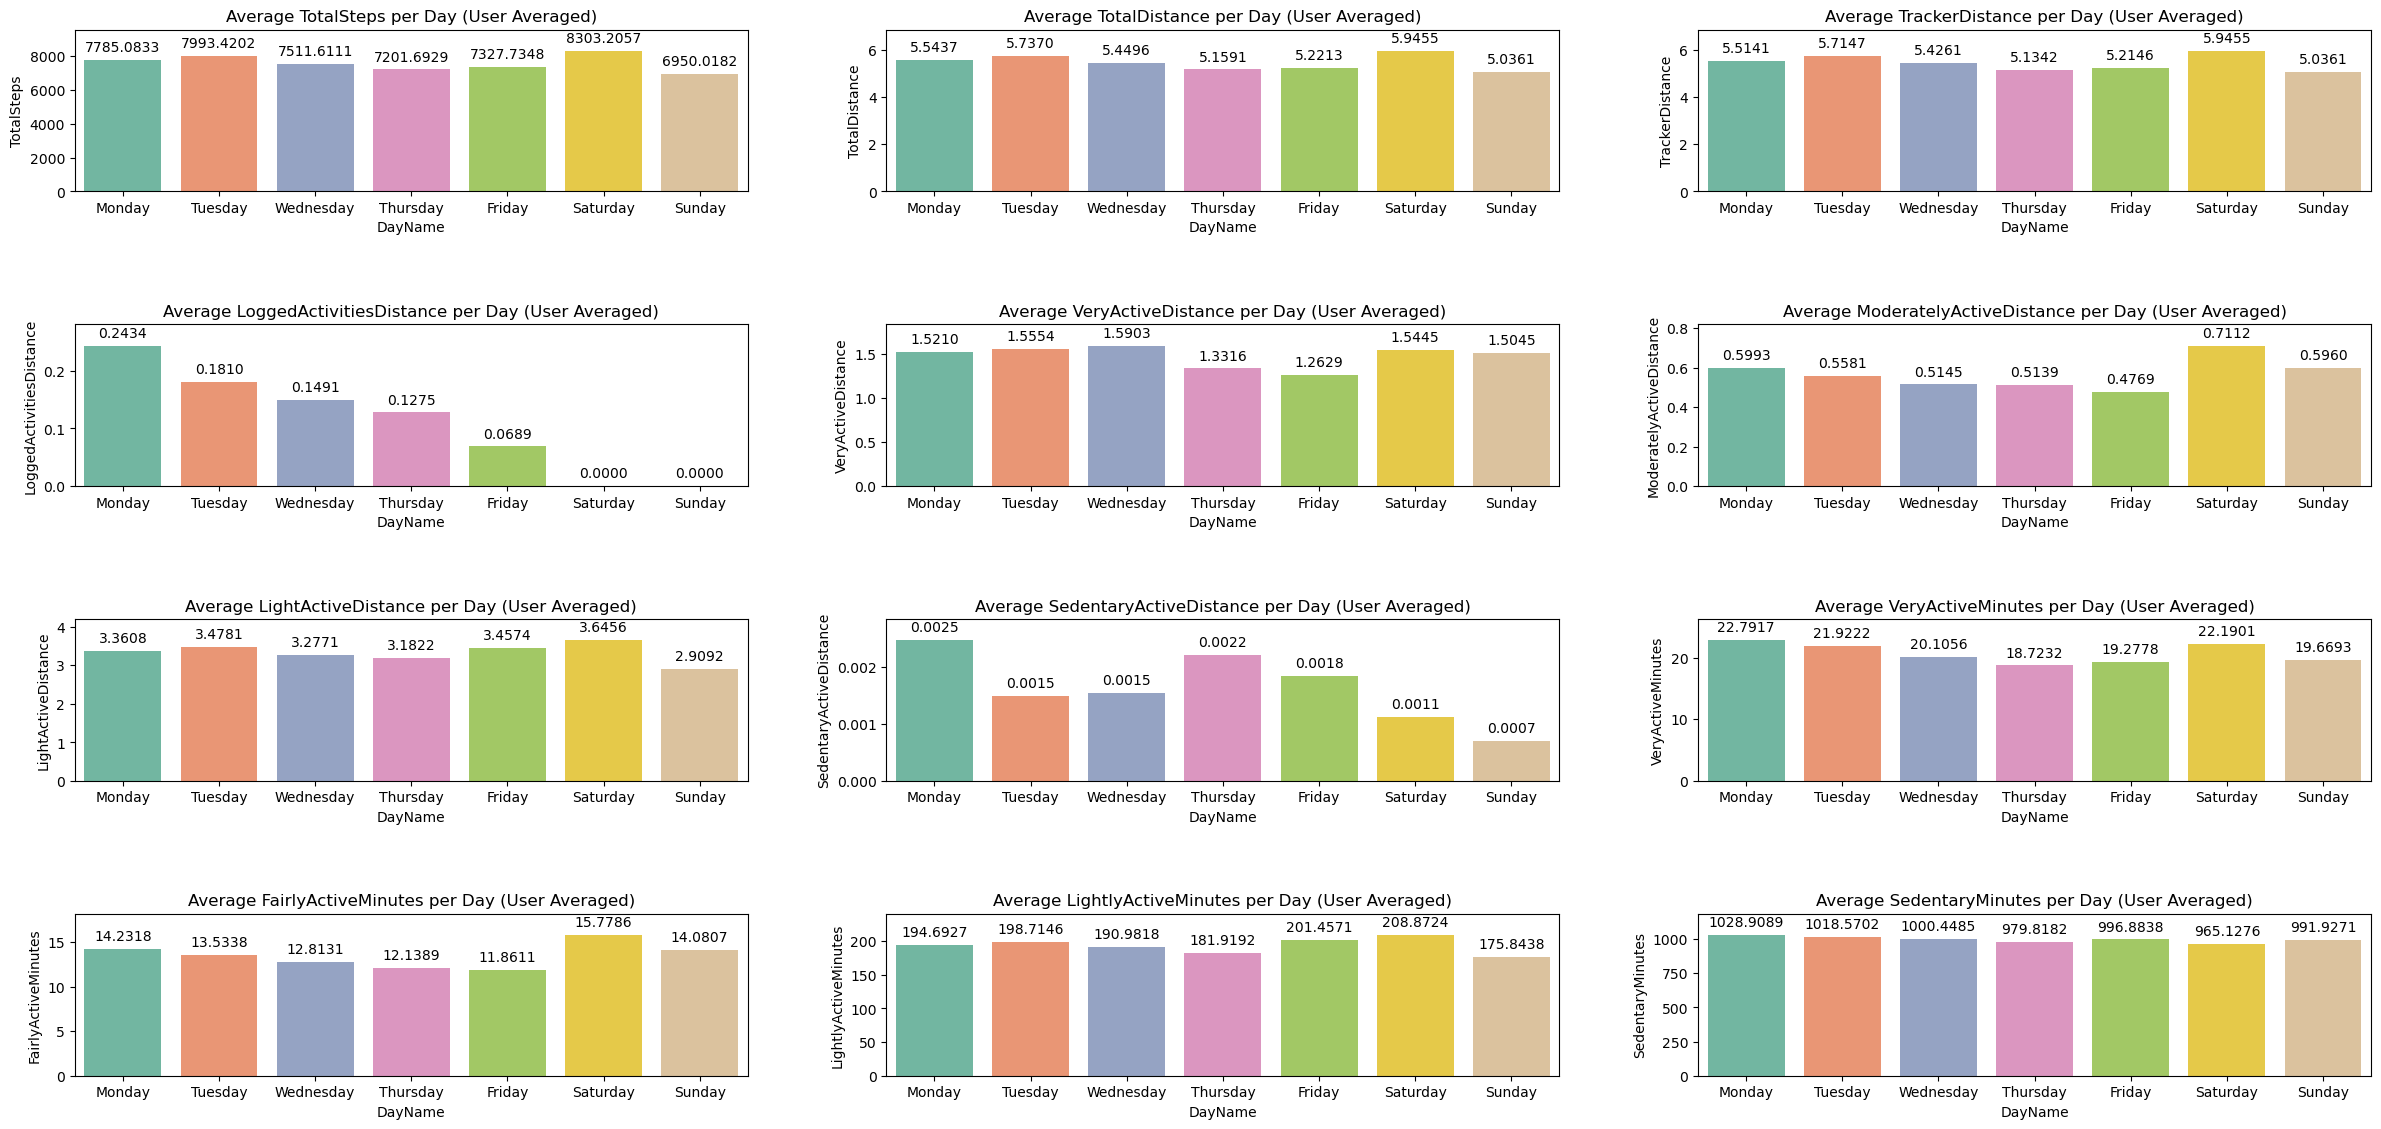

In [36]:
columns_to_check = [
    'TotalSteps', 'TotalDistance', 'TrackerDistance', 'LoggedActivitiesDistance', 
    'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 
    'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes', 
    'LightlyActiveMinutes', 'SedentaryMinutes']

# Hitung rata-rata aktivitas per hari untuk setiap pengguna
avg_per_user_per_day = df.groupby(['Id', 'DayName'])[columns_to_check].mean().reset_index()

# Sekarang hitung rata-rata aktivitas per hari di seluruh pengguna
avg_activity_per_day_all_users = avg_per_user_per_day.groupby('DayName')[columns_to_check].mean()

# Urutkan dari Senin sampai Minggu
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_activity_per_day_all_users = avg_activity_per_day_all_users.reindex(ordered_days)

plt.figure(figsize=(25, 15))
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(5, 3, i)  # Menampilkan 5 baris dan 3 kolom plot
    ax = sns.barplot(x=avg_activity_per_day_all_users.index, y=avg_activity_per_day_all_users[column], palette=sns.color_palette("Set2"))
    
    # Tambah margin di y-axis untuk memberi ruang di atas bar
    ax.set_ylim(0, avg_activity_per_day_all_users[column].max() * 1.15)

    plt.title(f'Average {column} per Day')
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), textcoords = 'offset points')
    
    plt.title(f'Average {column} per Day (User Averaged)')
    plt.tight_layout(pad=5)
# plt.tight_layout(pad=5)
plt.show()

- Pola hanya ditemukan pada plot LoggedActivitiesDistance dan SedentaryActiveDistance. 
- Pada LoggedActivitiesDistance, dapat dilihat bahwa user tidak menginput aktivitas yang mereka lakukan pada Sabtu dan Minggu (weekend), dan hanya ada sedikit aktivitas yang diinput manual pada hari Jum'at. 
- Pada SedentaryActiveDistance, rata-rata terendah terdapat pada hari Minggu, pengguna lebih sedikit bergerak secara ringan pada hari tersebut. Artinya, mereka cenderung lebih sering duduk diam atau tidak bergerak sama sekali.